# 사용 함수 정의

In [1]:
import pandas as pd
import warnings
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from datetime import datetime
import joblib
import os
from plugins import connector

warnings.filterwarnings('ignore')

def extract_data(cur, sql):
    cur.execute(sql)
    columns = [desc[0] for desc in cur.description]
    results = cur.fetchall()
    print(f'{len(results)}행 추출 완료')
    df = pd.DataFrame(results)
    df.columns = columns
    print('데이터프레임 생성 완료')
    return df

# REDSHIFT 데이터 추출(sql 쿼리는 원하면 수정)

In [2]:
conn, cur = connector.redshift_connector()

# sql 수정 후에 사용해도 좋음
# 내가 생각하기에 쓸모 없다고 생각하는 데이터는 뺐음
sql = '''
    SELECT
        P.place_id,
        P.area_congest_id,
        P.area_ppltn_min,
        P.area_ppltn_max,
        W.temp,
        W.sensible_temp,
        W.humidity,
        W.wind_dirct,
        W.wind_spd,
        W.precipitation,
        W.uv_index_lvl,
        W.pm25,
        W.pm10,
        W.air_idx_mvl,
        DATE_PART('year', W.created_date) AS year,
        DATE_PART('month', W.created_date) AS month,
        DATE_PART('day', W.created_date) AS day,
        DATE_PART('hour', W.created_date) AS hour,
        DATE_PART('minute', W.created_date) AS minute,
        EXTRACT(DOW FROM W.created_date) AS dow
    FROM
        "raw"."population" AS P
    JOIN
        "raw"."weather" AS W ON P.place_id = W.place_id AND P.created_date = W.created_date;
    '''
    
df = extract_data(cur, sql)
df.info()

Redshift에 연결되었습니다.
30816행 추출 완료
데이터프레임 생성 완료
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30816 entries, 0 to 30815
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   place_id         30816 non-null  int64  
 1   area_congest_id  30816 non-null  int64  
 2   area_ppltn_min   30816 non-null  int64  
 3   area_ppltn_max   30816 non-null  int64  
 4   temp             30816 non-null  float64
 5   sensible_temp    30816 non-null  float64
 6   humidity         30816 non-null  int64  
 7   wind_dirct       30816 non-null  object 
 8   wind_spd         30816 non-null  float64
 9   precipitation    30816 non-null  float64
 10  uv_index_lvl     30816 non-null  int64  
 11  pm25             30816 non-null  int64  
 12  pm10             30816 non-null  int64  
 13  air_idx_mvl      30816 non-null  int64  
 14  year             30816 non-null  float64
 15  month            30816 non-null  float64
 16  day          

# 모델 학습 및 예측

In [3]:
# 사용 컬럼 정의(호영이 골라도됨)
# dow는 요일 -> 0 : 일요일, 1 : 월요일 , 2 : 화요일, 3: 수요일, 4: 목요일, 5: 금요일, 6 : 토요일
use_columns = ['place_id', 'area_congest_id', 'temp', 'humidity', 'pm25', 'pm10', 'year', 'month', 'hour', 'dow']
df = df[use_columns]

# categorical_feature
categorical_feature = ['place_id', 'area_congest_id', 'year', 'month', 'hour', 'dow']
df[categorical_feature] = df[categorical_feature].astype('int').astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30816 entries, 0 to 30815
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   place_id         30816 non-null  category
 1   area_congest_id  30816 non-null  category
 2   temp             30816 non-null  float64 
 3   humidity         30816 non-null  int64   
 4   pm25             30816 non-null  int64   
 5   pm10             30816 non-null  int64   
 6   year             30816 non-null  category
 7   month            30816 non-null  category
 8   hour             30816 non-null  category
 9   dow              30816 non-null  category
dtypes: category(6), float64(1), int64(3)
memory usage: 1.1 MB


In [4]:
# 특성과 타겟 데이터 분할
X = df[['place_id','temp', 'humidity', 'pm25', 'pm10', 'year', 'month', 'hour', 'dow']]
y = df['area_congest_id']

# K-Fold 교차 검증 수행
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []

for train_idx, test_idx in kfold.split(X):
    # 훈련 세트와 테스트 세트 분할
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Random Forest 모델 생성 및 학습
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 테스트 세트에 대한 예측
    y_pred = model.predict(X_test)

    # 정확도 평가 및 저장
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# 평균 정확도 계산
mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print('Mean Accuracy:', mean_accuracy)

Mean Accuracy: 0.8824638211141135


# 모델 정확도 시각화

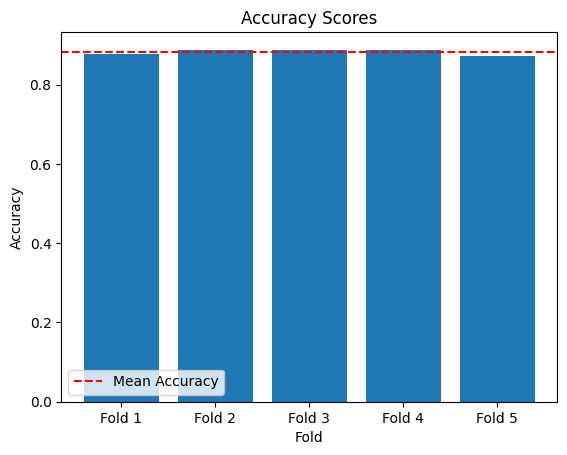

In [5]:
import matplotlib.pyplot as plt

# 정확도 시각화
fold_labels = [f'Fold {i+1}' for i in range(len(accuracy_scores))]
plt.bar(fold_labels, accuracy_scores)
plt.axhline(mean_accuracy, color='r', linestyle='--', label='Mean Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores')
plt.legend()
plt.show()

# 모델 저장 및 S3 업로드

In [6]:
# 모델 저장
now_dt = datetime.now().strftime('%Y%m%d')
model_path = f'./model/random_forest_model_{now_dt}.pkl'
filePath, fileName = os.path.split(model_path)
joblib.dump(model, model_path)


# s3 연결
s3 = connector.s3_connector()

# S3 업로드
with open(model_path, 'rb') as file:
    s3.put_object(
        Body = file,
        Bucket = 'standupseoul',
        Key = 'models/ml/' + fileName,
        # ContentType = 'application/x-pickle
    )

# 모델 로드 및 간이검증

In [7]:
model = joblib.load(model_path)

o_cnt = 0
x_cnt = 0
for idx in range(30000,30051):
    answer = df.loc[idx, 'area_congest_id']
    data = list(df.loc[idx, ['place_id', 'temp', 'humidity', 'pm25', 'pm10','year', 'month', 'hour', 'dow']])
    predict = model.predict([data])
    
    if answer == predict[0]:
        print(f'정답 : 정답은 {answer}, 예측값은 {predict}입니다.')
        o_cnt +=1
    else:
        print(f'오답 : 정답은 {answer}, 예측값은 {predict}입니다.')
        x_cnt +=1

print(f'정답 개수는 {o_cnt}')
print(f'오답 개수는 {x_cnt}')

정답 : 정답은 2, 예측값은 [2]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
오답 : 정답은 3, 예측값은 [2]입니다.
정답 : 정답은 4, 예측값은 [4]입니다.
정답 : 정답은 4, 예측값은 [4]입니다.
정답 : 정답은 4, 예측값은 [4]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
정답 : 정답은 2, 예측값은 [2]입니다.
정답 : 정답은 3, 예측값은 [3]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
정답 : 정답은 2, 예측값은 [2]입니다.
정답 : 정답은 3, 예측값은 [3]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
정답 : 정답은 3, 예측값은 [3]입니다.
정답 : 정답은 3, 예측값은 [3]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
정답 : 정답은 2, 예측값은 [2]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
정답 : 정답은 3, 예측값은 [3]입니다.
정답 : 정답은 4, 예측값은 [4]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
정답 : 정답은 3, 예측값은 [3]입니다.
정답 : 정답은 2, 예측값은 [2]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
정답 : 정답은 2, 예측값은 [2]입니다.
정답 : 정답은 2, 예측값은 [2]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
정답 : 정답은 2, 예측값은 [2]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
정답 : 정답은 2, 예측값은 [2]입니다.
정답 : 정답은 1, 예측값은 [1]입니다.
정답 : 정답은 2, 예측값은 [2]입니다.


In [8]:
data = [42, 24.7, 30, 10, 17, 2023, 6, 19, 13]
predict = model.predict([data])
predict

array([4])

In [9]:
df[df['area_congest_id'] == 4]

,place_id,area_congest_id,temp,humidity,pm25,pm10,year,month,hour,dow
5,6,4,23.1,40,10,31,2023,6,19,6
22,43,4,24.0,35,8,34,2023,6,19,6
26,42,4,23.3,33,8,34,2023,6,20,6
27,48,4,23.4,40,11,29,2023,6,20,6
39,43,4,23.7,34,8,34,2023,6,20,6
...,...,...,...,...,...,...,...,...,...,...
30414,47,4,25.5,60,8,22,2023,6,19,5
30423,38,4,23.7,45,10,18,2023,6,19,5
30454,6,4,24.7,40,12,25,2023,6,20,5
30488,43,4,24.5,48,8,17,2023,6,21,5
